In [934]:
import numpy as np
import fractions
import sys
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ipywidgets import Button, GridBox, ButtonStyle, Layout, HBox, VBox
from netgraph import Graph
import os.path
np.set_printoptions(threshold=sys.maxsize)
# np.set_printoptions(formatter={'all':lambda x: str(fractions.Fraction(x).limit_denominator())})

In [935]:
N = 7
START_POSITION = 24
END_POSITION1 = 6
END_POSITION2 = 48
END_POSITION = [END_POSITION1, END_POSITION2]

time_labels = False
absorption_labels = False

In [936]:
horizontal_walls = (np.array(sum([[k+l*N for k in range(N-1)] for l in range(N)], [])),
np.array(sum([[l*N+k+1 for k in range(N-1)] for l in range(N)], [])))
vertical_walls = (np.array(sum([[k+l*N for k in range(N)] for l in range(N-1)], [])),
np.array(sum([[k+l*N+N for k in range(N)] for l in range(N-1)], [])))

if os.path.isfile(f"graph_matrix{N}.npy"):
    graph_matrix = np.load(f"graph_matrix{N}.npy")
else:
    graph_matrix = np.zeros([N**2,N**2])
    graph_matrix[horizontal_walls] = 1
    graph_matrix[vertical_walls] = 1
    graph_matrix = (graph_matrix + graph_matrix.T).astype(int)

def get_transition_matrix(graph_matrix):
    transition_matrix = (graph_matrix.T/graph_matrix.sum(1)).T
    transition_matrix[END_POSITION] = 0
    transition_matrix[END_POSITION,END_POSITION] = 1
    return transition_matrix

def get_absorption_probability(transition_matrix):
    try:
        system = transition_matrix-np.eye(N**2)
        system[END_POSITION] = np.eye(N**2)[END_POSITION]
        return np.array([np.linalg.solve(system, np.eye(N**2)[position]) for position in END_POSITION]).T
    except:
        return np.linalg.matrix_power(transition_matrix,10000)[END_POSITION].T

def get_absorption_time(transition_matrix):
    try:
        temp = transition_matrix.copy()
        temp[:,[END_POSITION]] = 0
        b = [0 if k in END_POSITION else 1 for k in range(N**2)]
        A = np.eye(N**2)-temp
        return (np.linalg.inv(A)@b)
    except:
        return np.repeat(np.nan, (N**2))

In [937]:
def to_position(k):
    return np.array([k%N, (N-1)-(k-k%N)/N])

layout = {k:np.array(to_position(k)) for k in range(N**2)}

def plot_labyrinth(graph_matrix, layout, time_labels = False, absorption_labels = False, walls = True, edge_width = 1):
    clear_output(wait=True)

    transition_matrix = get_transition_matrix(graph_matrix)
    absorption_probability = get_absorption_probability(transition_matrix)
    absorption_time = get_absorption_time(transition_matrix)
    
    sources, targets = np.where(graph_matrix)
    weights = graph_matrix[sources, targets]
    edges = list(zip(sources, targets))
    # edge_labels = dict(zip(edges, weights))
    fig, ax = plt.subplots()
    Graph(edges, edge_label_position=0.5, edge_width = edge_width, edge_label_fontdict=dict(size=10, fontweight='bold'),
            arrows=True, ax=ax, node_layout = layout)
    
    for k in range(N**2):
        color = "green" if k == START_POSITION else "deeppink" if k == END_POSITION1 else "red" if k == END_POSITION2 else "black"
        ax.text(*to_position(k)+np.array([-0.05,-0.05]), f"{k}", color = color)
        expected_absorption = absorption_time[k]
        if time_labels:
            ax.text(*to_position(k)+np.array([-0.15,0.3]), f"{expected_absorption:.1f}", color = color, fontsize=7)
        if absorption_labels:
            ax.text(*to_position(k)+np.array([-0.2,0.25]), f"{absorption_probability[k,0]:.2f}", color = "deeppink", fontsize=7)
            ax.text(*to_position(k)+np.array([-0.2,-0.25]), f"{absorption_probability[k,1]:.2f}", color = "red", fontsize=7)

    #Labyrinth contour
    ax.plot([-0.5,-0.5],[-0.5,N-1+0.5], "black")
    ax.plot([N-1+0.5,-0.5],[N-1+0.5,N-1+0.5], "black")
    ax.plot([-0.5,N-1+0.5], [-0.5,-0.5], "black")
    ax.plot([N-1+0.5,N-1+0.5],[N-1+0.5,-0.5], "black")

    if walls:
        for k in range(len(horizontal_walls[0])):
            k1 = horizontal_walls[0][k]
            k2 = horizontal_walls[1][k]
            if graph_matrix[k1,k2] == 0:
                x1,y1 = to_position(k1)
                x2,y2 = to_position(k2)
                ax.plot([x1+0.5]*2,[y1-0.5,y2+0.5], "black")

        for k in range(len(vertical_walls[0])):
            k1 = vertical_walls[0][k]
            k2 = vertical_walls[1][k]
            if graph_matrix[k1,k2] == 0:
                x1,y1 = to_position(k1)
                x2,y2 = to_position(k2)
                ax.plot([x1-0.5,x2+0.5],[y1-0.5]*2, "black")
    plt.show()
    return ax

In [938]:
def button_type(k):
    i,j = (k%(2*N-1),int((k-k%(2*N-1))/(2*N-1)))
    if i%2 == 0 and j%2 == 0:
        return 0
    elif i%2 == 1 and j%2 == 0:
        return 1
    elif i%2 == 0 and j%2 == 1:
        return 2
    else:
        return 3
    
def button_color(k, graph_matrix):
    the_type = button_type(k)
    i,j = (k%(2*N-1),(k-k%(2*N-1))/(2*N-1))
    if the_type == 0:
        node = int(i/2 + (N)*(j)/2)
        if node == START_POSITION:
            return "green"
        elif node == END_POSITION1:
            return "deeppink"
        elif node == END_POSITION2:
            return "red"
        else:
            return "skyblue"
    elif the_type == 1:
        wall_type = list(zip(*horizontal_walls))
        wall_number = int((i-1)/2 + (N-1)* j/2)
        k1,k2 = wall_type[wall_number]
    elif the_type == 2:
        wall_type = list(zip(*vertical_walls))
        wall_number = int(i/2 + (N)*(j-1)/2)
        k1,k2 = wall_type[wall_number]
    else:
        return "black"
    color = "skyblue" if graph_matrix[k1,k2] == 1 else "black"
    return color
    
def wallbutton_action(b, graph_matrix, buttons):
    k = buttons.index(b)
    the_type = button_type(k)
    i,j = (k%(2*N-1),(k-k%(2*N-1))/(2*N-1))
    if the_type == 1:
        wall_type = list(zip(*horizontal_walls))
        wall_number = int((i-1)/2 + (N-1)* j/2)
        k1,k2 = wall_type[wall_number]
    else:
        wall_type = list(zip(*vertical_walls))
        wall_number = int(i/2 + (N)*(j-1)/2)
        k1,k2 = wall_type[wall_number]
    graph_matrix[k1,k2] = 1 - graph_matrix[k1,k2]
    graph_matrix[k2,k1] = 1 - graph_matrix[k2,k1]
    color = "skyblue" if graph_matrix[k1,k2] == 1 else "black"
    b.style.button_color = color
    plot_labyrinth(graph_matrix, layout, time_labels=time_labels,absorption_labels=absorption_labels)

def switch_variable(b, variable):
    variable = bool(1 - variable)
    plot_labyrinth(graph_matrix, layout)

def initialize_buttons(buttons, graph_matrix):
    for k in range((2*N-1)**2):
        the_type = button_type(k)
        if the_type == 1 or the_type == 2:
            buttons[k].on_click(lambda b: wallbutton_action(b, graph_matrix, buttons))
        elif the_type == 0:
            i,j = (k%(2*N-1),(k-k%(2*N-1))/(2*N-1))
            buttons[k].description = str(int(i/2 + (N)*(j)/2))

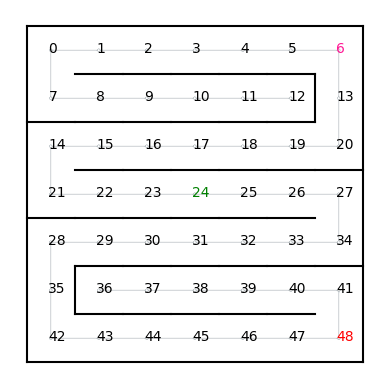

<Axes: >

In [939]:
buttons = [Button(layout=Layout(width='auto', height='auto'),style=ButtonStyle(button_color=button_color(k,graph_matrix))) for k in range((2*N-1)**2)]
initialize_buttons(buttons,graph_matrix)
buttons_grid = GridBox(children=buttons,
        layout=Layout(
            width='50%',
            grid_template_columns=f'{300/N}px 25px '*(N-1)+f'{300/N}px',
            grid_template_rows=f'{300/N}px 25px '*(N-1)+f'{300/N}px',
            grid_gap='0px 0px')
       )

plot_labyrinth(graph_matrix, layout, time_labels=time_labels, absorption_labels=absorption_labels)

In [940]:
buttons_grid

GridBox(children=(Button(description='0', layout=Layout(height='auto', width='auto'), style=ButtonStyle(button…

In [941]:
# name = int(np.ceil(get_absorption_time(get_transition_matrix(graph_matrix))[24]))
# plot_labyrinth(graph_matrix, layout).figure.savefig(f"../pictures/{name}-1.png",bbox_inches='tight')
# plot_labyrinth(graph_matrix, layout, time_labels=True,).figure.savefig(f"../pictures/{name}-2.png",bbox_inches='tight')
# plot_labyrinth(graph_matrix, layout, absorption_labels=True,).figure.savefig(f"../pictures/{name}-3.png",bbox_inches='tight')
# plot_labyrinth(graph_matrix, layout, walls = False, edge_width=10).figure.savefig(f"../pictures/{name}-4.png",bbox_inches='tight')

In [942]:
np.save(f'graph_matrix{N}.npy', graph_matrix)